# GARLIC demo

General-purpose Adaptive Richardson-Lucy Image Characterisation

# 1. Initialisation

## Import libraries and scripts

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import ipywidgets as widgets
from IPython.display import display

import numpy as np
from time import time
from scipy import ndimage

import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

Plotting:

In [2]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(fig_name)
    
    return fig, axes

In [3]:
default_cmap = plt.get_cmap("gist_earth").copy()
default_cmap.set_bad('gray')


def colour_map(ax, cblabel, data, cmap=default_cmap, norm=None, xlabel=None, x=None, ylabel=None, y=None):
    
    if norm is None:
        percentiles = np.array([1, 16, 50, 84, 99])
        ticks = np.nanpercentile(data, percentiles)
        linthresh = np.median(data[data > 0])
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=linthresh)
    else:
        ticks = None
    if y is None:
        y = np.arange(data.shape[0])
    if x is None:
        x = np.arange(data.shape[1])

    im = ax.imshow(data,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, y[0]-(y[1]-y[0])/2, y[-1]+(y[-1]-y[-2])/2),
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    #ax.set_aspect('auto')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(cblabel)
    if ticks is not None:
        cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)])
    cb.ax.tick_params(labelsize='small')
    
    return im, cb


## Read data

In [4]:
importlib.reload(scripts.read_data)
object_name, data, true_spectrum = scripts.read_data.run(11, (0, 0, 1))
data_offset = np.nanmin(data)

Read dataset 11: "Sky spectrum" (7341,) (0.0118 s)


## Parameter settings

In [5]:
resolution_boost = 4
original_pixel = np.arange(data.size * resolution_boost) / resolution_boost  # used for plotting

In [6]:
n_radii = 100
min_scale = resolution_boost
max_scale = np.sqrt(data.size * resolution_boost)  # reasonable upper limit
smoothing_radii = np.logspace(np.log10(min_scale), np.log10(max_scale), n_radii)

In [7]:
residual_accuracy = .1
max_iter = 100  # in principle, just for safety

# 2. Background estimation

In [23]:
importlib.reload(scripts.multiscale_RL)
boosted_data, mRL = scripts.multiscale_RL.run(data, smoothing_radii, resolution_boost, residual_accuracy, max_iter)

iteration 1/100: rms_residual = 1.26e+03 (+97.87%)
iteration 2/100: rms_residual = 7.60e+02 (-65.12%)
iteration 3/100: rms_residual = 4.78e+02 (-59.08%)
iteration 4/100: rms_residual = 3.00e+02 (-59.12%)
iteration 5/100: rms_residual = 1.98e+02 (-51.89%)
iteration 6/100: rms_residual = 1.41e+02 (-40.25%)
iteration 7/100: rms_residual = 1.11e+02 (-27.50%)
iteration 8/100: rms_residual = 9.42e+01 (-17.37%)
iteration 9/100: rms_residual = 8.48e+01 (-11.13%)
iteration 10/100: rms_residual = 7.86e+01 (-7.84%)
Multiscale Richardson-Lucy deconvolution (8.8 s)


In [24]:
# mean and variance of values below mean
mu = np.mean(mRL, axis=1)
mRL_background = np.where(mRL < mu[:, np.newaxis], mRL, np.nan)
mu0 = np.nanmean(mRL_background, axis=1)
var0 = np.nanvar(mRL_background, axis=1)

# weighted mean and variance of all values
mRL_background = np.exp(-.5 * (mRL - mu0[:, np.newaxis])**2 / var0[:, np.newaxis])
total_weight = np.nansum(mRL_background, axis=1)
mu1 = np.nansum(mRL * mRL_background, axis=1) / total_weight
var1 = np.nansum((mRL - mu1[:, np.newaxis])**2 * mRL_background, axis=1) / total_weight

# corrected mean and variance
var = 1 / (1/var1 - 1/var0)
mu = var * (mu1/var1 - mu0/var0)

In [25]:
#mRL_background = mRL * np.exp(-.5 * (mRL - mu[:, np.newaxis]).clip(min=0)**2 / var[:, np.newaxis])
mRL_background = np.fmin(mRL, mu[:, np.newaxis])

In [36]:
background = np.zeros_like(boosted_data)
background += data_offset
for i, radius in enumerate(smoothing_radii):
    background += ndimage.gaussian_filter(mRL_background[i], radius)
#mRL_sources = (mRL-mRL_background).clip(min=0)

# 3. Source finding

In [37]:
importlib.reload(scripts.multiscale_RL)
boosted_sources, mRL_sources = scripts.multiscale_RL.run(data-np.interp(np.arange(data.size), original_pixel, background), smoothing_radii, resolution_boost, residual_accuracy, max_iter)

iteration 1/100: rms_residual = 1.25e+03 (+100.00%)
iteration 2/100: rms_residual = 7.57e+02 (-65.05%)
iteration 3/100: rms_residual = 4.76e+02 (-59.10%)
iteration 4/100: rms_residual = 2.97e+02 (-60.09%)
iteration 5/100: rms_residual = 1.94e+02 (-53.08%)
iteration 6/100: rms_residual = 1.38e+02 (-40.92%)
iteration 7/100: rms_residual = 1.08e+02 (-27.40%)
iteration 8/100: rms_residual = 9.25e+01 (-16.89%)
iteration 9/100: rms_residual = 8.36e+01 (-10.67%)
iteration 10/100: rms_residual = 7.78e+01 (-7.52%)
Multiscale Richardson-Lucy deconvolution (8.73 s)


In [38]:
mRL_estimate = background.copy()
for i, radius in enumerate(smoothing_radii):
    mRL_estimate += ndimage.gaussian_filter(mRL_sources[i], radius)
rms_residual = np.std(boosted_data - mRL_estimate)
print(rms_residual, np.nanstd(mRL_estimate.flat[1:]-mRL_estimate.flat[:-1])/np.sqrt(2), np.nanstd(data.flat[1:]-data.flat[:-1])/np.sqrt(2))

73.29811894764349 61.36283264141262 265.30359260640716


## Hierarchical Overdensity Tree

In [39]:
importlib.reload(scripts.sort_data)
#argsorted_data, n_valid = scripts.sort_data.run(RL.ravel())
argsorted_data, n_valid = scripts.sort_data.run(mRL_sources.ravel())

Sorted 2936400 finite measurements in ascending order (0.317 s)


In [40]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(mRL.strides)//mRL.itemsize, mRL.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
HOT_labels, HOT_catalog = scripts.HOT.run(mRL_sources, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

HOT: 729 overdensities found, 2936400 "pixels" (100%), 7 independent regions
     2.19 seconds


In [41]:
HOT_parent = HOT_catalog[0]
HOT_area = HOT_catalog[1]
HOT_test_stat = HOT_catalog[2]
HOT_bg = HOT_catalog[3]
#max_test_stat = catalog[3]

## Individual sources

In [42]:
def get_individual_mRL(mRL, labels, target):

    mRL_target = np.zeros_like(mRL)
    indices = np.where(labels == target)
    mRL_target[indices] = mRL[indices]
    '''
    RL[target] = mRL[target] - bg[lbl]
    children = np.where(parent == lbl)[0]
    for child in np.unique(children[children != lbl]):
        print(child, bg[child], bg[lbl])
        target = np.where((self.label == child) | (parent[self.label] == child))
        RL[target] = bg[child] - bg[lbl]
    '''
    return mRL_target

# 3. Plots

Normalisation and color maps:

In [43]:
n_sources = np.unique(HOT_labels).size
latin_cube = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
latin_cube[0, :] = [0., 0., 0., 1.]  # background object must be black :^)
label_cmap = colors.ListedColormap(latin_cube)
label_norm = colors.Normalize(vmin=-.5, vmax=n_sources+.5)
print(f'{n_sources} unique sourcces')

729 unique sourcces


In [44]:
mRL_cmap = default_cmap
mRL_norm = colors.LogNorm(vmin=np.percentile(mRL[mRL>0], 10), vmax=np.percentile(mRL[mRL>0], 99))

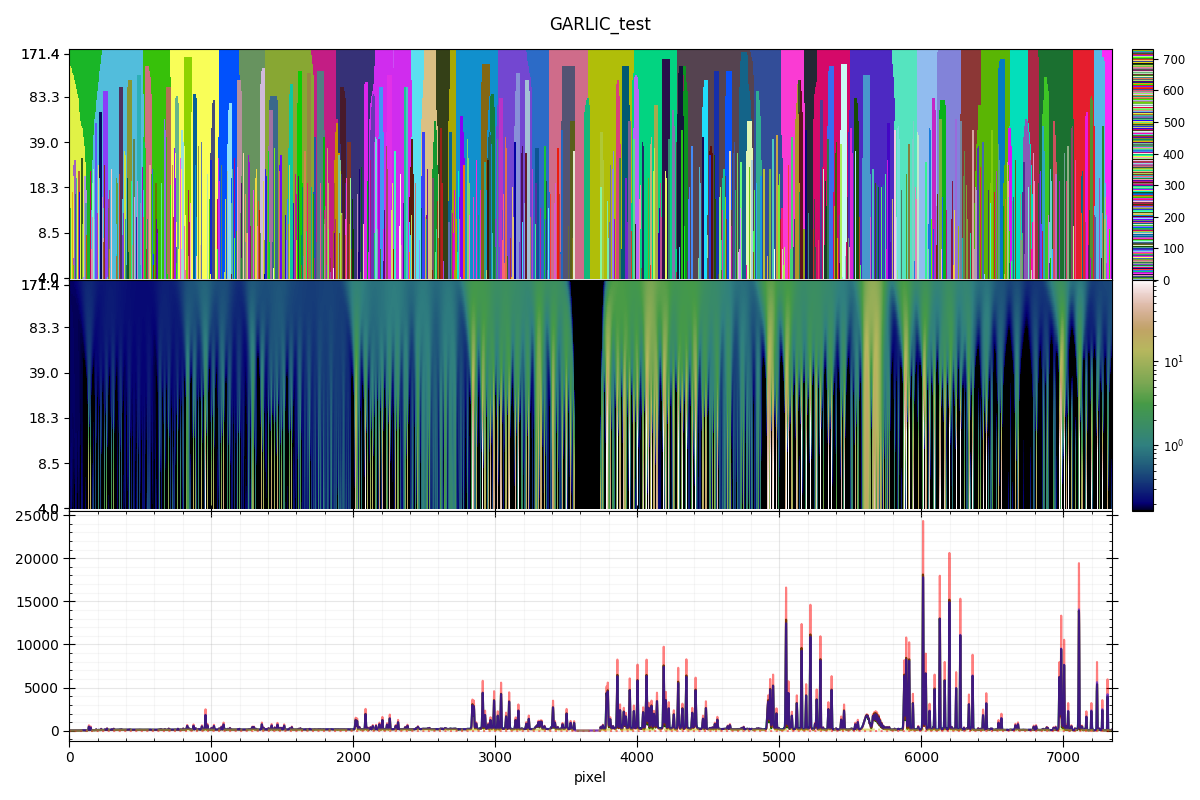

In [45]:
fig_name = 'GARLIC_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=3, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .02], 'hspace': 0})
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
#im = ax.imshow(label[np.newaxis, :],
im = ax.imshow(HOT_labels,
               extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
               interpolation='nearest', origin='lower', cmap=label_cmap, norm=label_norm,
              )
ax.set_aspect('auto')
ax.set_ylim(-1, n_radii+1)
ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
ax.set_yticks(ticks)
ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
cb = plt.colorbar(im, cax=axes[0, 1], orientation='vertical', shrink=.9)
cb.ax.tick_params(labelsize='small')


ax = axes[1, 0]
im = ax.imshow(mRL_sources,
               extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
               interpolation='nearest', origin='lower', cmap=mRL_cmap, norm=mRL_norm,
              )
ax.set_aspect('auto')
ax.set_ylim(-1, n_radii+1)
ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
ax.set_yticks(ticks)
ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
cb = plt.colorbar(im, cax=axes[1, 1], orientation='vertical', shrink=.9)
cb.ax.tick_params(labelsize='small')


ax = axes[2, 0]
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(true_spectrum, 'g-')
ax.plot(data, 'k-', alpha=.2)
ax.axhline(data_offset, c='r', ls=':', alpha=.5)
ax.plot(original_pixel, np.sum(mRL, axis=0) + data_offset, 'r-', alpha=.5)
ax.plot(original_pixel, mRL_estimate, 'b-', alpha=.5)
ax.plot(original_pixel, background, 'y-.', alpha=.5)


ax.set_xlabel('pixel')
#ax.set_xlim(5900, 6300)

axes[2, 1].axis('off')
plt.show()

interactive(children=(BoundedIntText(value=1, description='lbl', max=729, min=1), Output()), _dom_classes=('wi…

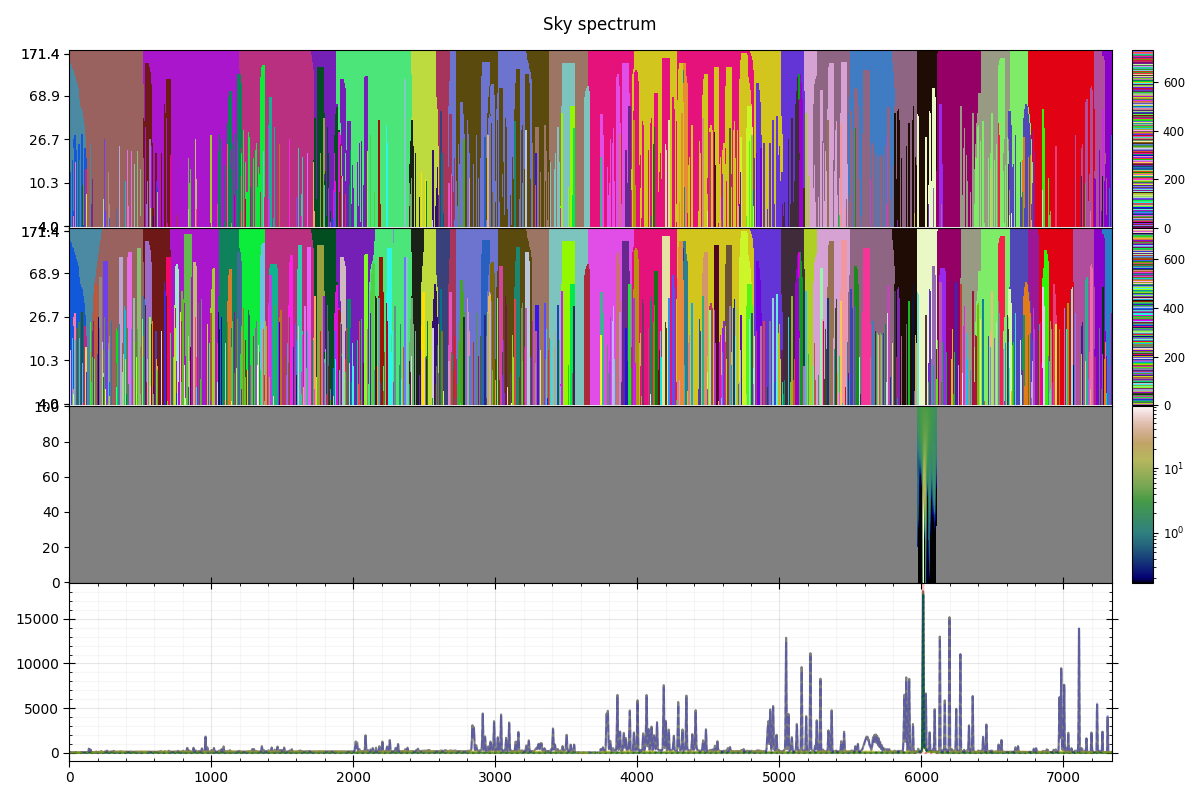

In [21]:
def get_mRL_inpaint(mRL, labels, target):

    mRL_target = np.zeros_like(mRL)
    indices = np.where(labels == target)
    mRL_target[indices] = mRL[indices]

    radius = np.sqrt(mRL.shape[0])
    inpaint_map = np.where(mRL_target > 0, 1., 0.)  # object mask
    inpaint_map = ndimage.gaussian_filter(inpaint_map, radius)  # interpolation weight
    inpaint_map = np.clip(inpaint_map, np.min(inpaint_map[inpaint_map > 0]), np.inf)  # to prevent division by zero
    inpaint_map = ndimage.gaussian_filter(mRL_target, radius) / inpaint_map

    return mRL_target, np.fmin(inpaint_map, mRL)


def get_individual_mRL(mRL, labels, parent, target):

    mRL_target, inpaint_map = get_mRL_inpaint(mRL, labels, target)
    
    # compute contribution to descendants:
    progenitor = parent[labels]
    if parent[target] == target:
        indices = np.where(labels == target)
        progenitor[indices] = 0
    n_found = 1
    while n_found > 0:
        indices = np.where(progenitor == target)
        n_found = len(indices[0])
        #print(f'{n_found} values painted')
        mRL_target[indices] = inpaint_map[indices]
        if parent[target] == target:
            progenitor[indices] = 0
        progenitor = parent[progenitor]

    # remove contribution from ancestors:
    '''
    RL[target] = mRL[target] - bg[lbl]
    '''

    return mRL_target


class Explore_lbl_1D(object):
    
    def __init__(self, fig_name, data, boosted_data, estimate, label, parent):
        """Interactive display"""
        
        plt.close(fig_name)
        self.fig = plt.figure(fig_name, figsize=(12, 8))
        self.axes = self.fig.subplots(nrows=4, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .02], 'hspace': 0})
        self.fig.suptitle(fig_name)
        self.fig.set_tight_layout(True)

        self.original = data
        self.boosted_data = boosted_data
        self.data_offset = np.nanmin(data)
        #self.RL = RL
        #self.SSF = SSF
        self.total_estimate = estimate
        self.label = label
        self.parent = parent

        self.ax_parent = self.axes[0, 0]
        self.ax_parent_cb = self.axes[0, 1]
        self.ax_lbl = self.axes[1, 0]
        self.ax_lbl_cb = self.axes[1, 1]

        self.ax_im = self.axes[2, 0]
        self.ax_cb = self.axes[2, 1]

        self.ax0 = self.axes[3, 0]
        self.ax0.plot(data, 'k-', alpha=.2)
        self.ax0.set_xlim(0, data.size)
        self.axes[3, 1].axis('off')

        self.widget = widgets.interactive(self.plot_lbl, lbl=widgets.BoundedIntText(value=1, min=1, max=n_sources, continuous_update=False))
        display(self.widget)


    def plot_lbl(self, lbl):
        xlim = self.ax0.get_xlim()
        ylim = self.ax0.get_ylim()

        ax = self.ax_parent
        im = ax.imshow(self.parent[self.label],
                       extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
                       interpolation='nearest', origin='lower',
                       cmap=label_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
                      )
        ax.set_aspect('auto')
        ax.set_ylim(-1, n_radii+1)
        ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
        cb = plt.colorbar(im, cax=self.ax_parent_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        
        
        ax = self.ax_lbl
        im = ax.imshow(self.label,
                       extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
                       interpolation='nearest', origin='lower',
                       cmap=label_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
                      )
        ax.set_aspect('auto')
        ax.set_ylim(-1, n_radii+1)
        ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
        cb = plt.colorbar(im, cax=self.ax_lbl_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')

        
        RL = get_individual_mRL(mRL, HOT_labels, HOT_parent, lbl)
        self.ax_im.clear()
        im = self.ax_im.imshow(RL,
                               extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
                               interpolation='nearest', origin='lower',
                               #cmap='gist_earth', norm=colors.LogNorm(vmin=np.min(RL[RL > 1e3*epsilon])))
                               #cmap=default_cmap, norm=colors.LogNorm(vmin=1/n_radii),
                               cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(mRL[mRL>0], 10), vmax=np.percentile(mRL[mRL>0], 99)),
                               #cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(RL[RL>0], 1), vmax=np.percentile(RL[RL>0], 99)),
                              )
        self.ax_im.set_aspect('auto')
        cb = plt.colorbar(im, cax=self.ax_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        self.fig.canvas.draw_idle()
        

        ax = self.ax0
        ax.clear()
        ax.plot(self.original, 'k-', alpha=.5)
        #self.ax0.plot(original_pixel, self.boosted_data + self.data_offset, 'k-')

        #RL = RL[np.newaxis, :] * self.SSF[:, np.newaxis]
        estimate = np.empty_like(RL)
        for i, radius in enumerate(smoothing_radii):
            #self.ax0.plot(original_pixel, RL[i], 'k-', alpha=.1)
            estimate[i] = ndimage.gaussian_filter(RL[i], radius)
        estimate = np.sum(estimate, axis=0)
        #print(np.min(estimate))
        
        fraction = estimate/self.total_estimate
        #estimate_data_offset = np.sum(estimate * ((self.boosted_data+self.data_offset)*fraction - estimate)) / np.sum(estimate)
        final_estimate = estimate #+ estimate_data_offset*np.sqrt(fraction/np.max(fraction))
        #print(estimate_data_offset, np.max(fraction))
        #estimate = self.boosted_data*fraction + self.data_offset*np.mean(fraction)
        #print(f'area: {np.sum(fraction):.2f} ({area[lbl]}),',
        #      f'flux: {np.nansum(final_estimate):.2f} ({test_stat[lbl]:.2f}),',
        mu = np.nansum(final_estimate) / np.count_nonzero(final_estimate > 0)
        print(f'area: {np.sum(fraction):.2f} ({np.count_nonzero(final_estimate[final_estimate <= mu] > 0)} + {np.count_nonzero(final_estimate[final_estimate > mu] > 0)} = {np.count_nonzero(final_estimate > 0)}),',
              f'flux: {np.nansum(final_estimate):.2f} ({np.nansum(final_estimate[final_estimate <= mu]):.2f}, {np.nansum(final_estimate[final_estimate > mu]):.2f}),',
              f'min-max:{np.min(self.boosted_data*fraction):.2f}-{np.max(self.boosted_data*fraction):.2f},'
              f'mean:{mu:.3f}',
              f'rms:{np.sum((fraction*self.boosted_data)**2)/np.sum(self.boosted_data*fraction):.3f}')
        print()

        #ax.plot(original_pixel, (self.boosted_data+self.data_offset)*fraction, 'r-.', alpha=.5)

        ax.axhline(data_offset, c='r', ls=':', alpha=.5)
        ax.plot(original_pixel, np.sum(RL, axis=0) + self.data_offset, 'r-', alpha=.25)
        ax.plot(original_pixel, estimate + self.data_offset, 'b:', alpha=.5)
        ax.plot(original_pixel, final_estimate, 'g-', alpha=.75)
        ax.plot(original_pixel, self.total_estimate + self.data_offset, 'b--', alpha=.25)
        ax.plot(original_pixel, background + data_offset, 'y-.', alpha=.5)

        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')
        #ax.set_yscale('log')
        ax.set_ylim(.9*self.data_offset, 3e5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #self.ax0.set_xlim(5000, 5300)


if len(data.shape) == 1:
    estimate = np.empty_like(mRL)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(mRL[i] - mRL_background[i], radius)
    estimate = np.sum(estimate, axis=0)
    rms_residual = np.std(boosted_data - estimate)

    #for i, radius in enumerate(smoothing_radii):
    #     mRL[i] *= ndimage.gaussian_filter((boosted_data+epsilon) / (estimate+epsilon), radius)
    #RL = np.nansum(mRL, axis=0)
    #SSF_amplitude = np.nanmedian(mRL/RL[np.newaxis, :], axis=1)
    #print(rms_residual)
    x = Explore_lbl_1D(object_name, data, boosted_data, estimate, HOT_labels, HOT_parent)

In [22]:
np.mean(mRL, axis=1)

array([15.66403585, 15.49640809, 15.31981377, 15.13114015, 14.93135869,
       14.72129311, 14.49758763, 14.26144887, 14.0125253 , 13.75055775,
       13.47681736, 13.18832964, 12.88675406, 12.57234435, 12.24552072,
       11.9068796 , 11.55720081, 11.19622533, 10.82752387, 10.45123427,
       10.06887176,  9.68120338,  9.29180236,  8.90175536,  8.51233745,
        8.12704346,  7.74666038,  7.37391276,  7.01107351,  6.65914051,
        6.32019419,  5.99564798,  5.68667967,  5.39420967,  5.1188901 ,
        4.86110428,  4.62086865,  4.39828642,  4.19283135,  4.00413005,
        3.83136681,  3.67380453,  3.53054276,  3.40062198,  3.28305125,
        3.1768329 ,  3.08096116,  2.9945341 ,  2.91660872,  2.8463651 ,
        2.78302851,  2.72589715,  2.67434349,  2.62780795,  2.58581451,
        2.54792969,  2.51378652,  2.4830583 ,  2.45545265,  2.43071066,
        2.4085872 ,  2.38885843,  2.37131125,  2.35574197,  2.34196008,
        2.32978411,  2.31904422,  2.30958329,  2.30125718,  2.29